<h1><center>
Semestrální práce z 4IZ566
    
## IBM HR Analytics Employee Attrition & Performance
    
### Jan Malý & Vojtěch Vávra</h1></center>

#### Budeme hledat:
* 1) nejlepší interpretovatelnost parametru
* 2) Nejnižší False Negative Rate, protože je nažádoucí špatně označit člověka co má úmysl odejít z práce jako člověka, který by chtěl zůstat


#### Použijeme k tomu:
* 1) Logistickou regresi
* 2) Rozhodovací strom
* 3) XGBOOST

#### Zdroj dat:
* https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset

### Naimpotrujeme si balíčky

In [1]:
import pandas as pd # used for working with data sets
import numpy as np # used for working with arrays
import time #for timing
from math import e

import matplotlib.pyplot as plt # used for plotting
import sklearn.metrics as metrics # Different evaluation metrics
import pickle
import xgboost as xgb

### Vytáhneme funkce a modely

In [2]:
# Usefull functions
from sklearn.model_selection import train_test_split # for split of data into training and testing part
from sklearn.metrics import mean_squared_error # MSE
from itertools import product #for expand grid
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import tree
from sklearn.metrics import accuracy_score


#pro interpretaci koeficientů
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris

# Used models
from sklearn.linear_model import ElasticNet # Elasticnet regression
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression # Logistic regression

# 0) Úvodní práce s daty
* zahození nepotřebných dat
* příprava dummy proměných

### Zasejeme
* pro stálost výsledků

In [3]:
SEED=1512

### Importace dat pro oba dva pracovníky zvlášť

In [4]:
# Honza
#path_to_data = "C:/Users/honza/OneDrive/Desktop/Ing. - 3.semestr/Python a R/IBM_data.csv"
# Vojta
path_to_data = "D:/Documents/FIS VŠE/02 MAGISTR/3. semestr/Python a R/Python/semestralka/IBM_data.csv"

data = pd.read_csv(path_to_data)
data_dummy = pd.read_csv(path_to_data)

### Zahodíme nepotřebné

* DailyRate, Monthly Income a MonthlyRate dropnuto protože bude používání proměnná HourlyRate
* EmployeeCount je ve všech řádcích 1, EmployeeNumber je ID
* Over18 a StandartHours jsou ve všech pozorováních stejná (Yes a 80)

In [5]:
data = data.drop(['DailyRate','EmployeeCount','EmployeeNumber','MonthlyIncome','MonthlyRate','Over18','StandardHours'],axis=1)
data['Attrition']=data['Attrition']=='Yes'

data_dummy = data_dummy.drop(['DailyRate','EmployeeCount','EmployeeNumber','MonthlyIncome','MonthlyRate','Over18','StandardHours'],axis=1)
data_dummy['Attrition']=data_dummy['Attrition']=='Yes'

### Drobná úprava názvů sloupců
* pro lepší práci
* a zahození již nepotřebných údajů

In [6]:
travel_mapping={'Travel_Rarely':2,'Travel_Frequently':3,'Non-Travel':1}


data_dummy['Male']=data_dummy['Gender']=='Male'
data_dummy['BusinessTravel']=data_dummy['BusinessTravel'].map(travel_mapping)
data_dummy['Sales']=data_dummy['Department']=='Sales'
data_dummy['R&D']=data_dummy['Department']=='Research & Development'
data_dummy['HR']=data_dummy['Department']=='Human Resources'
data_dummy['EDU_LS']=data_dummy['EducationField']=='Life Sciences'
data_dummy['EDU_Oth']=data_dummy['EducationField']=='Other'
data_dummy['EDU_Med']=data_dummy['EducationField']=='Medical'
data_dummy['EDU_Mark']=data_dummy['EducationField']=='Marketing'
data_dummy['EDU_Tech']=data_dummy['EducationField']=='Technical Degree'
data_dummy['EDU_HR']=data_dummy['EducationField']=='Human Resources'
data_dummy['JOB_SE']=data_dummy['JobRole']=='Sales Executive'
data_dummy['JOB_RS']=data_dummy['JobRole']=='Research Scientist'
data_dummy['JOB_LT']=data_dummy['JobRole']=='Laboratory Technician'
data_dummy['JOB_MD']=data_dummy['JobRole']=='Manufacturing Director'
data_dummy['JOB_HCR']=data_dummy['JobRole']=='Healthcare Representative'
data_dummy['JOB_MA']=data_dummy['JobRole']=='Manager'
data_dummy['JOB_SR']=data_dummy['JobRole']=='Sales Representative'
data_dummy['JOB_RD']=data_dummy['JobRole']=='Research Director'
data_dummy['JOB_HR']=data_dummy['JobRole']=='Human Resources'
data_dummy['Single']=data_dummy['MaritalStatus']=='Single'
data_dummy['Married']=data_dummy['MaritalStatus']=='Married'
data_dummy['Divorced']=data_dummy['MaritalStatus']=='Divorced'
data_dummy['OverTime']=data_dummy['OverTime']=='Yes'

data_dummy=data_dummy.drop(['Gender','Department','EducationField','JobRole','MaritalStatus'],axis=1)

### Uložení dat
* opět každý má svoji cestu

In [7]:
# Honza
#data_dummy.to_csv("C:/Users/honza/OneDrive/Desktop/Ing. - 3.semestr/Python a R/IBM_data_dummy.csv")
# Vojta
#data_dummy.to_csv("D:/Documents/FIS VŠE/02 MAGISTR/3. semestr/Python a R/Python/semestralka/IBM_data_dummy.csv")

### Zobrazení dat

In [8]:
data.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,True,Travel_Rarely,Sales,1,2,Life Sciences,2,Female,94,...,3,1,0,8,0,1,6,4,0,5
1,49,False,Travel_Frequently,Research & Development,8,1,Life Sciences,3,Male,61,...,4,4,1,10,3,3,10,7,1,7
2,37,True,Travel_Rarely,Research & Development,2,2,Other,4,Male,92,...,3,2,0,7,3,3,0,0,0,0
3,33,False,Travel_Frequently,Research & Development,3,4,Life Sciences,4,Female,56,...,3,3,0,8,3,3,8,7,3,0
4,27,False,Travel_Rarely,Research & Development,2,1,Medical,1,Male,40,...,3,4,1,6,3,3,2,2,2,2


In [9]:
data_dummy.head()

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JOB_LT,JOB_MD,JOB_HCR,JOB_MA,JOB_SR,JOB_RD,JOB_HR,Single,Married,Divorced
0,41,True,2,1,2,2,94,3,2,4,...,False,False,False,False,False,False,False,True,False,False
1,49,False,3,8,1,3,61,2,2,2,...,False,False,False,False,False,False,False,False,True,False
2,37,True,2,2,2,4,92,2,1,3,...,True,False,False,False,False,False,False,True,False,False
3,33,False,3,3,4,4,56,3,1,3,...,False,False,False,False,False,False,False,False,True,False
4,27,False,2,2,1,1,40,3,1,2,...,True,False,False,False,False,False,False,False,True,False


## Rozdělení dat na trénovací a testovací

In [10]:
train_ratio = 0.70
test_ratio = 0.30

# Split the dataset into training_validation and testing part
X_train, X_test, y_train, y_test = train_test_split(
    data_dummy.drop(['Attrition'], axis = 1), # explanatory variable
    data_dummy[['Attrition']], # response variable
    test_size = test_ratio, # hold out size
    random_state = SEED
    )

x_lab=list(X_train)
x_lab

['Age',
 'BusinessTravel',
 'DistanceFromHome',
 'Education',
 'EnvironmentSatisfaction',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobSatisfaction',
 'NumCompaniesWorked',
 'OverTime',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'Male',
 'Sales',
 'R&D',
 'HR',
 'EDU_LS',
 'EDU_Oth',
 'EDU_Med',
 'EDU_Mark',
 'EDU_Tech',
 'EDU_HR',
 'JOB_SE',
 'JOB_RS',
 'JOB_LT',
 'JOB_MD',
 'JOB_HCR',
 'JOB_MA',
 'JOB_SR',
 'JOB_RD',
 'JOB_HR',
 'Single',
 'Married',
 'Divorced']

### Podíváme se na pár grafů

In [11]:
data_dummy.info()
print(data_dummy.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Age                       1470 non-null   int64
 1   Attrition                 1470 non-null   bool 
 2   BusinessTravel            1470 non-null   int64
 3   DistanceFromHome          1470 non-null   int64
 4   Education                 1470 non-null   int64
 5   EnvironmentSatisfaction   1470 non-null   int64
 6   HourlyRate                1470 non-null   int64
 7   JobInvolvement            1470 non-null   int64
 8   JobLevel                  1470 non-null   int64
 9   JobSatisfaction           1470 non-null   int64
 10  NumCompaniesWorked        1470 non-null   int64
 11  OverTime                  1470 non-null   bool 
 12  PercentSalaryHike         1470 non-null   int64
 13  PerformanceRating         1470 non-null   int64
 14  RelationshipSatisfaction  1470 non-null 

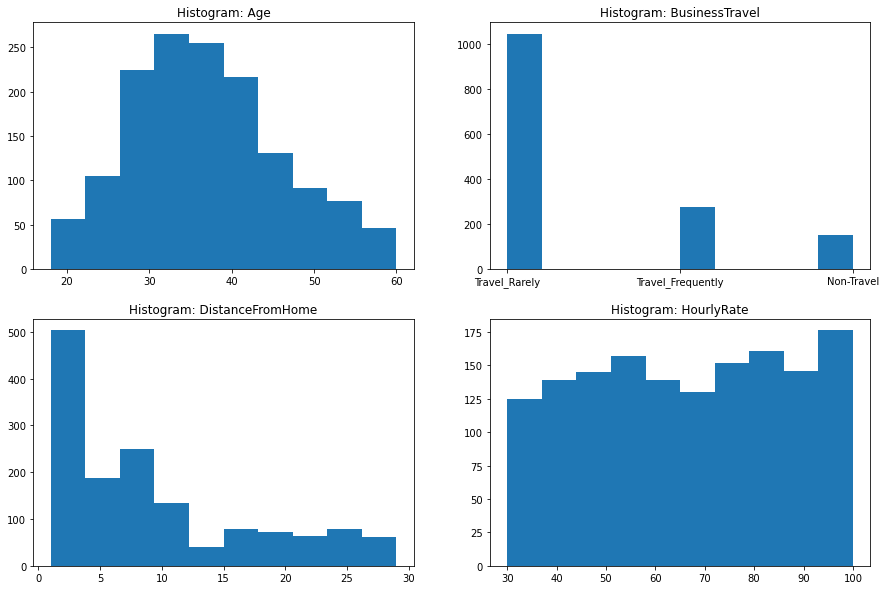

In [12]:
fig = plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.hist(data['Age'])
plt.title('Histogram: Age')

plt.subplot(2,2,2)
plt.hist(data['BusinessTravel'])
plt.title('Histogram: BusinessTravel')

plt.subplot(2,2,3)
plt.hist(data['DistanceFromHome'])
plt.title('Histogram: DistanceFromHome')

plt.subplot(2,2,4)
plt.hist(data['HourlyRate'])
plt.title('Histogram: HourlyRate')

plt.show()

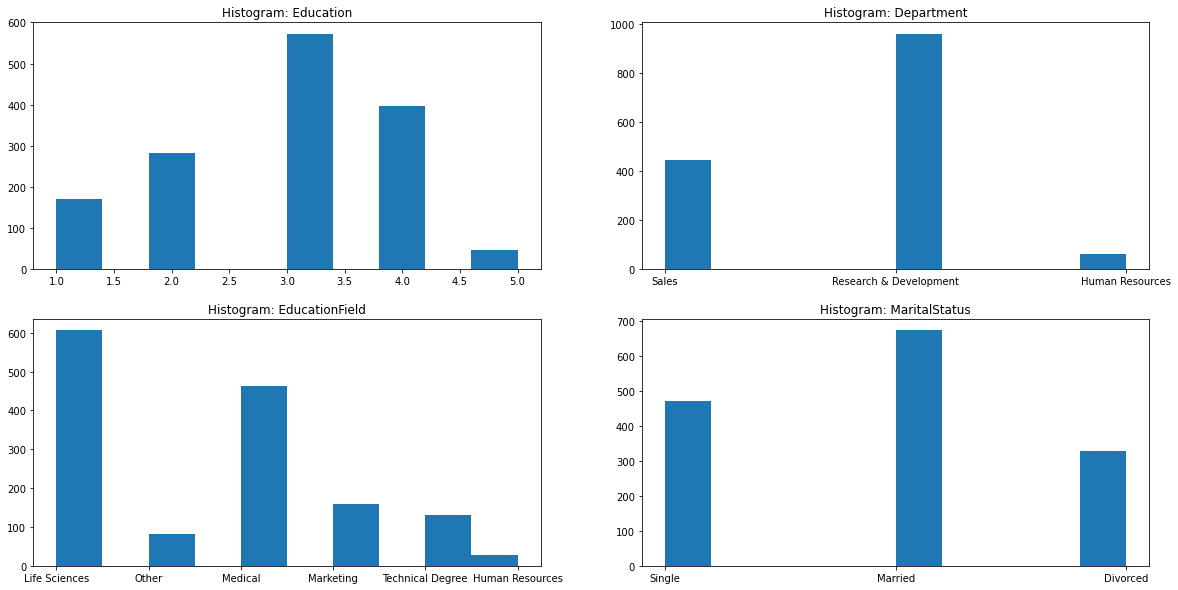

In [13]:
fig = plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.hist(data['Education'])
plt.title('Histogram: Education')

plt.subplot(2,2,2)
plt.hist(data['Department'])
plt.title('Histogram: Department')

plt.subplot(2,2,3)
plt.hist(data['EducationField'])
plt.title('Histogram: EducationField')

plt.subplot(2,2,4)
plt.hist(data['MaritalStatus'])
plt.title('Histogram: MaritalStatus')

plt.show()

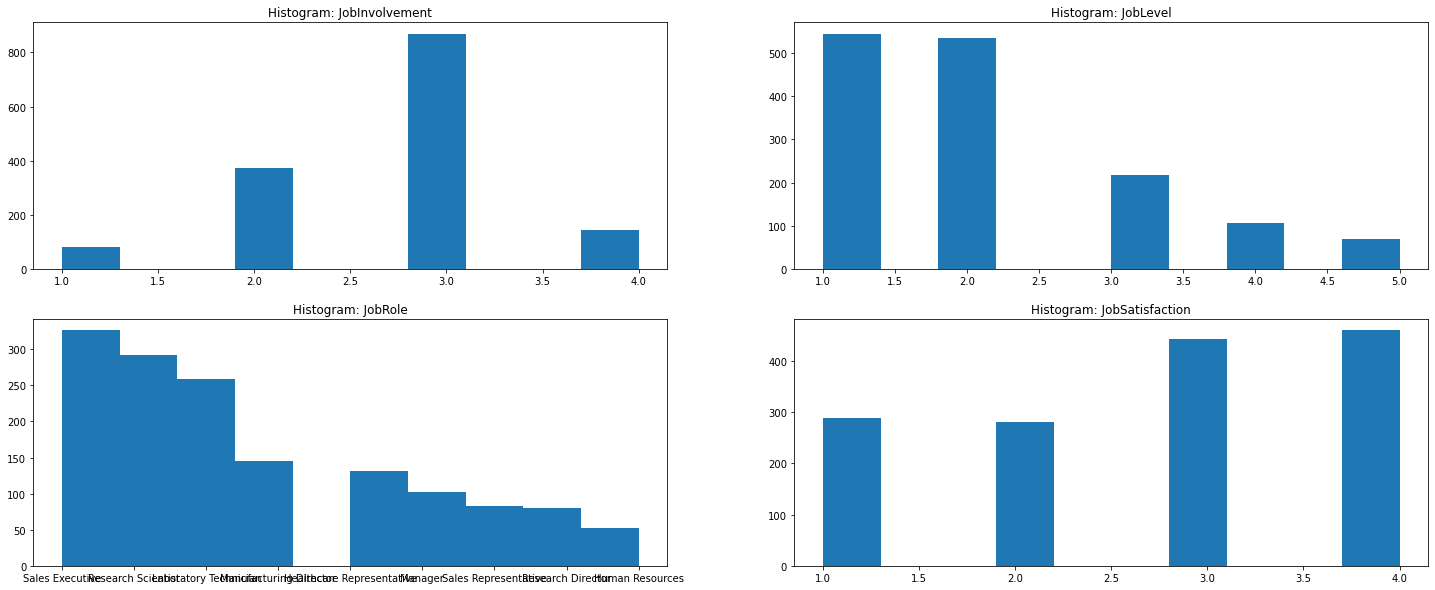

In [14]:
fig = plt.figure(figsize=(25,10))
plt.subplot(2,2,1)
plt.hist(data['JobInvolvement'])
plt.title('Histogram: JobInvolvement')

plt.subplot(2,2,2)
plt.hist(data['JobLevel'])
plt.title('Histogram: JobLevel')

plt.subplot(2,2,3)
plt.hist(data['JobRole'])
plt.title('Histogram: JobRole')

plt.subplot(2,2,4)
plt.hist(data['JobSatisfaction'])
plt.title('Histogram: JobSatisfaction')

plt.show()

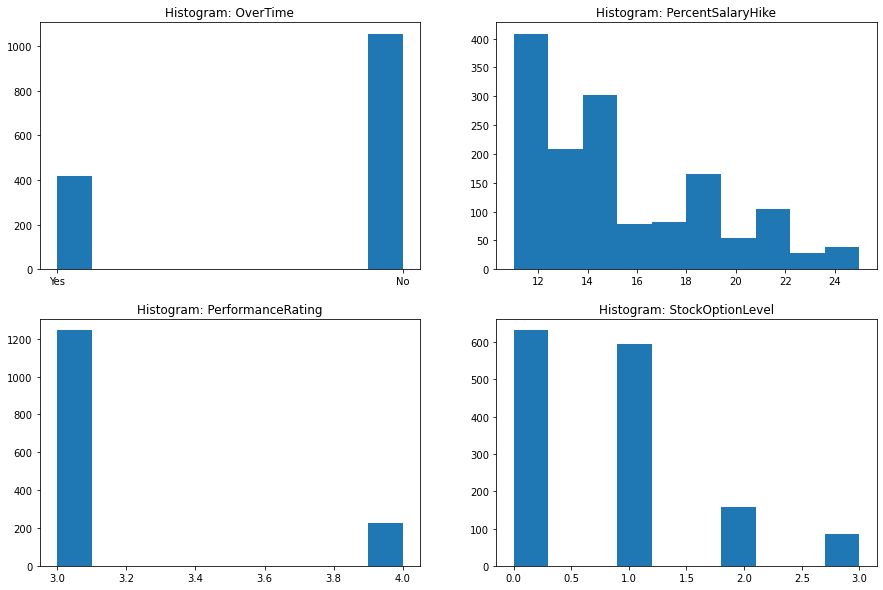

In [15]:
fig = plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.hist(data['OverTime'])
plt.title('Histogram: OverTime')

plt.subplot(2,2,2)
plt.hist(data['PercentSalaryHike'])
plt.title('Histogram: PercentSalaryHike')

plt.subplot(2,2,3)
plt.hist(data['PerformanceRating'])
plt.title('Histogram: PerformanceRating')

plt.subplot(2,2,4)
plt.hist(data['StockOptionLevel'])
plt.title('Histogram: StockOptionLevel')

plt.show()

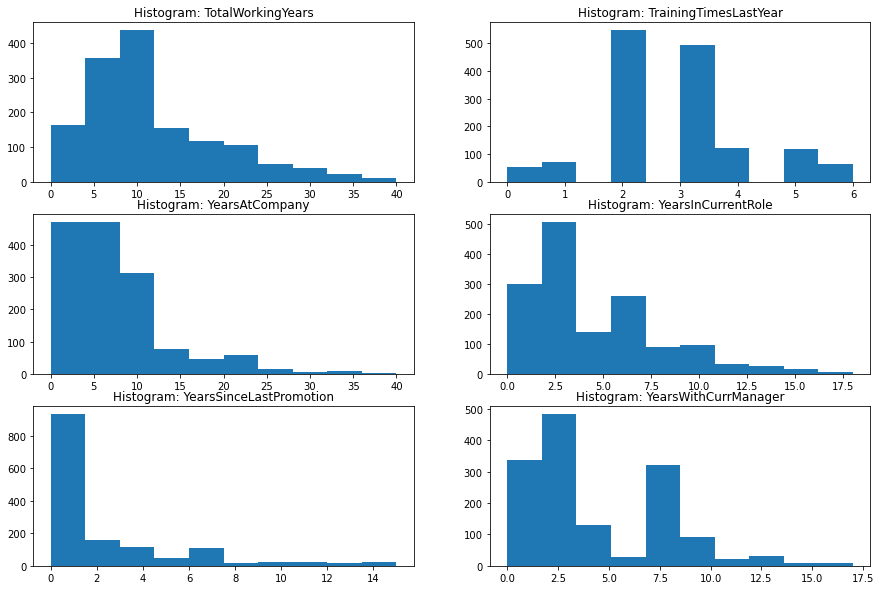

In [16]:
fig = plt.figure(figsize=(15,10))
plt.subplot(3,2,1)
plt.hist(data['TotalWorkingYears'])
plt.title('Histogram: TotalWorkingYears')

plt.subplot(3,2,2)
plt.hist(data['TrainingTimesLastYear'])
plt.title('Histogram: TrainingTimesLastYear')

plt.subplot(3,2,3)
plt.hist(data['YearsAtCompany'])
plt.title('Histogram: YearsAtCompany')

plt.subplot(3,2,4)
plt.hist(data['YearsInCurrentRole'])
plt.title('Histogram: YearsInCurrentRole')

plt.subplot(3,2,5)
plt.hist(data['YearsSinceLastPromotion'])
plt.title('Histogram: YearsSinceLastPromotion')

plt.subplot(3,2,6)
plt.hist(data['YearsWithCurrManager'])
plt.title('Histogram: YearsWithCurrManager')

plt.show()

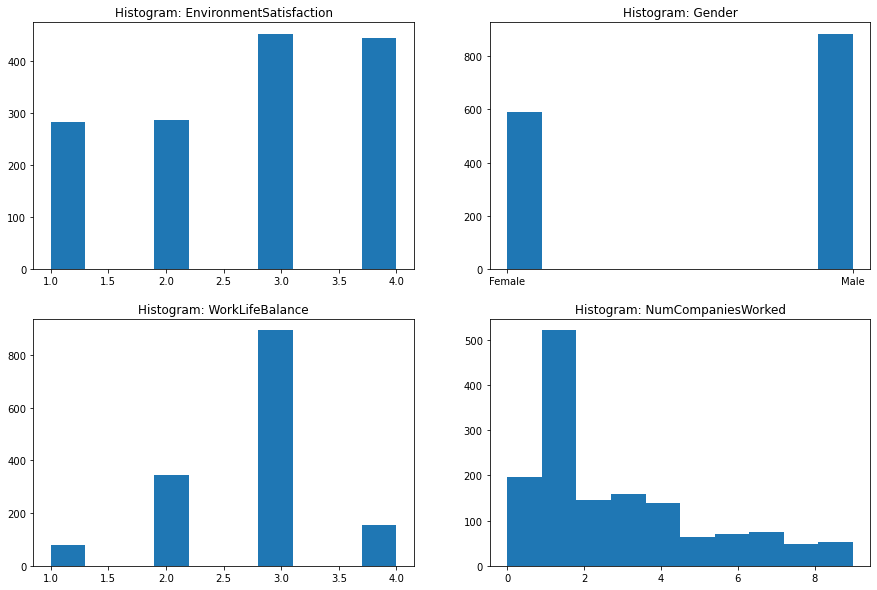

In [17]:
fig = plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.hist(data['EnvironmentSatisfaction'])
plt.title('Histogram: EnvironmentSatisfaction')

plt.subplot(2,2,2)
plt.hist(data['Gender'])
plt.title('Histogram: Gender')

plt.subplot(2,2,3)
plt.hist(data['WorkLifeBalance'])
plt.title('Histogram: WorkLifeBalance')

plt.subplot(2,2,4)
plt.hist(data['NumCompaniesWorked'])
plt.title('Histogram: NumCompaniesWorked')

plt.show()

# 1) Logistická regrese

### Výpočty
* Binary logistic regression
* Multinomic logistic regression

In [18]:
logistic_model = LogisticRegression(
  fit_intercept = True,
  random_state = SEED)

hyper_grid_log = {'penalty': ('l1', 'l2', 'elasticnet', 'none')
               }


grid_search_log = GridSearchCV(estimator = logistic_model, 
                            param_grid = hyper_grid_log, 
                            cv = 10, #specify the number of folds
                            n_jobs = -1, #n_jobs...Number of jobs to run in parallel. -1 means using all processors. 
                            verbose = 2 #controls verbosity of the model
                        ) 


grid_search_log.fit(X_train, y_train)
#best parameters
print(grid_search_log.best_params_)
#best estimator
log_mod_opt= grid_search_log.best_estimator_
# Predict the test set labels
y_pred_log = log_mod_opt.predict(X_test)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
{'penalty': 'l2'}


D:\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.89408909        nan 0.89021512]
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* drobné obtíže s iteracemi směle ignorujeme

### Graf

<Figure size 1080x1080 with 0 Axes>

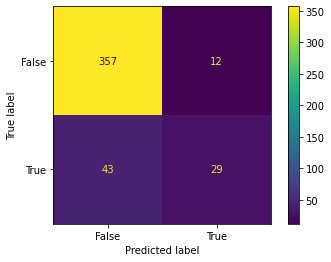

In [19]:
fig = plt.figure(figsize=(15,15))
plot_confusion_matrix(grid_search_log, X_test, y_test)  
plt.show()

### Metriky

In [20]:
cnf_log=confusion_matrix(y_test,y_pred_log)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred_log)) # ((TP+TN)/total) 
print("Precision:",metrics.precision_score(y_test, y_pred_log)) # (TP/(TP + FP)) 
print("Recall:",metrics.recall_score(y_test, y_pred_log)) # (TP/(TP + FN)) 
print("False Negative Rate:",cnf_log[1,0]/cnf_log.sum()) # (TP/(TP + FN)) 

Accuracy: 0.8752834467120182
Precision: 0.7073170731707317
Recall: 0.4027777777777778
False Negative Rate: 0.09750566893424037


### AUC a ROC křivky
* predikujeme True Positive Rate (TPR) a False Positive Rate (FPR) pro různá odvětví
* agregujeme AUC křivku
* AUC = Area Under the Curve

In [21]:
y_proba_log = grid_search_log.predict_proba(X_test)[::,1]
fpr_log, tpr_log, threshold_log = metrics.roc_curve(y_test, y_proba_log)

auc = metrics.roc_auc_score(y_test, y_proba_log)

### AUC a ROC křivky graf

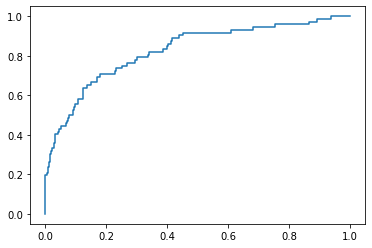

In [22]:
# ROC curve - Performance of a classification model at all classification thresholds.
# X axes - TPR (TP/(TP + FN)), Y axes - FPR (FP/(FP + TN))
plt.plot(fpr_log,tpr_log,label="data 1, auc="+str(auc))
plt.show()

### Interpretace regresorů

In [23]:

c=grid_search_log.best_estimator_.coef_
ones=np.ones(44)
ones.fill(2.71828182846)
exp=np.power(ones,c)
expc = np.insert(c, 1, exp, axis=0)
coef=np.transpose(expc)
coef_pd=pd.DataFrame(coef, columns = ['Coef','Exp Coef'], index = x_lab)
coef_pd

,Coef,Exp Coef
Age,-0.026780,0.973576
BusinessTravel,1.234573,3.436910
DistanceFromHome,0.051147,1.052477
Education,-0.094472,0.909853
EnvironmentSatisfaction,-0.395540,0.673317
HourlyRate,0.003583,1.003590
JobInvolvement,-0.405620,0.666564
JobLevel,-0.430829,0.649970
JobSatisfaction,-0.423995,0.654427
NumCompaniesWorked,0.202796,1.224822


# 2) Decision tree

### Příprava pro rozhodovací strom
* nabídneme možnosti, ze kterých bude vybírat nejlepší

In [24]:
tree_model = DecisionTreeClassifier()

#optimize hyper parameters
# Create the grid
hyper_grid_tree = {"max_depth": [1, 2, 5, 10, 20, 30],
               "min_samples_leaf": [0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
               }

### Grid search model

In [25]:
grid_search_tree = GridSearchCV(estimator = tree_model, 
                          param_grid = hyper_grid_tree, 
                          cv = 3, 
                          n_jobs = -1, 
                          verbose = 2
                          )

grid_search_tree.fit(X_train, y_train)
tree_best=grid_search_tree.best_params_
print(grid_search_tree.best_params_)   
tree_mod_opt= grid_search_tree.best_estimator_  
y_pred_tree = tree_mod_opt.predict(X_test)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
{'max_depth': 5, 'min_samples_leaf': 0.05}


* Nejlepší kombinace v {} složených ("chlupatých") závorkách.

### graf

<Figure size 1080x1080 with 0 Axes>

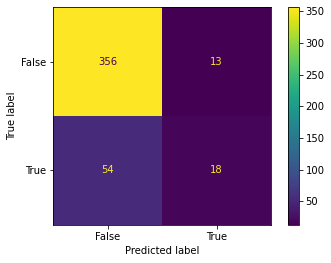

In [26]:
fig = plt.figure(figsize=(15,15))
plot_confusion_matrix(grid_search_tree, X_test, y_test)  
plt.show()

### Spočítej metriky

In [27]:
cnf_tree=confusion_matrix(y_test,y_pred_tree)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred_tree)) # ((TP+TN)/total) 
print("Precision:",metrics.precision_score(y_test, y_pred_tree)) # (TP/(TP + FP)) 
print("Recall:",metrics.recall_score(y_test, y_pred_tree)) # (TP/(TP + FN)) 
print("False Negative Rate:",cnf_tree[1,0]/cnf_tree.sum()) # (TP/(TP + FN)) 

Accuracy: 0.8480725623582767
Precision: 0.5806451612903226
Recall: 0.25
False Negative Rate: 0.12244897959183673


### AUC a ROC křivky
* predikujeme True Positive Rate (TPR) a False Positive Rate (FPR) pro různá odvětví
* agregujeme AUC křivku
* AUC = Area Under the Curve

In [28]:
y_proba_tree = grid_search_tree.predict_proba(X_test)[::,1]
fpr_tree, tpr_tree, threshold_tree = metrics.roc_curve(y_test, y_proba_tree)

auc = metrics.roc_auc_score(y_test, y_proba_tree)

### AUC a ROC křivka - graf

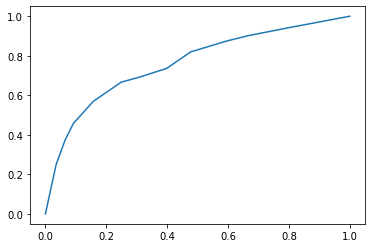

In [29]:
# ROC curve - Performance of a classification model at all classification thresholds.
# X axes - TPR (TP/(TP + FN)), Y axes - FPR (FP/(FP + TN))
plt.plot(fpr_tree,tpr_tree,label="data 1, auc="+str(auc))
plt.show()

### Vyobrazení stromu

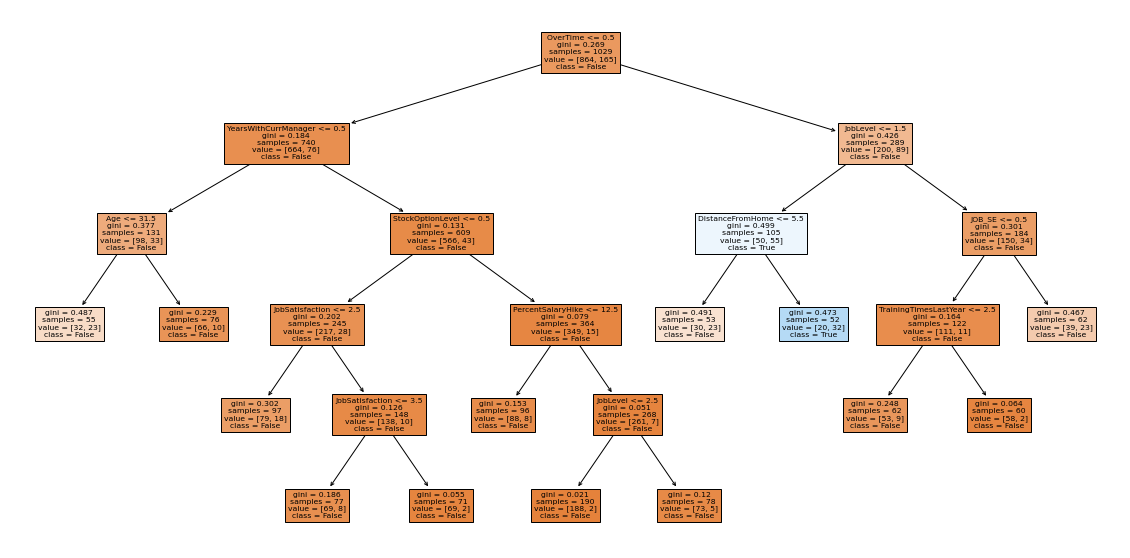

In [30]:
fig = plt.figure(figsize=(20,10))
_ = tree.plot_tree(tree_mod_opt, 
                  feature_names=x_lab, 
                  class_names=('False','True'),
                  filled=True)

plt.show()

# 3) XGBOOST

Kdyby nechtělo fungovat, je třeba naistalovat mimo jupyter notebook:

In [31]:
# conda install -c conda-forge xgboost
# conda install -c conda-forge/label/gcc7 xgboost
# conda install -c conda-forge/label/cf201901 xgboost
# conda install -c conda-forge/label/cf202003 xgboost

### Příprava

In [32]:
param_grid = {'learning_rate': [0.1,0.5,0.7], #alias eta, Step size shrinkage used in update to prevents overfitting.  
    'n_estimators': [50,100,150], 
    'subsample': [0.5,0.7,0.9], #Subsample ratio of the training instances
    'max_depth': [1,5],
    'colsample_bytree': [0.1,0.5,0.7] #colsample_bytree is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.
    }

#instantiate XGBRegressor 
gbm = xgb.XGBRegressor(seed=SEED, objective='binary:hinge')
grid_mse = GridSearchCV(estimator=gbm,
                        param_grid=param_grid,
                        scoring='accuracy',
                        cv=5, 
                        verbose=1, 
                        n_jobs=-1)

### Parametr scoringu - věrohodnost modelu / křížové entropie
* fitujeme GridSearchCV

In [33]:
tic = time.perf_counter() #begin timing
grid_mse.fit(X_train, y_train)
time_fit_cv = time.perf_counter() - tic #save timer
print(time_fit_cv)

gbm_ins = grid_mse.best_estimator_ #best_estimator_
print(gbm_ins)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
20.7595946
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.7, max_delta_step=0,
             max_depth=1, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=150, n_jobs=12,
             num_parallel_tree=1, objective='binary:hinge', predictor='auto',
             random_state=1512, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=None, seed=1512, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)


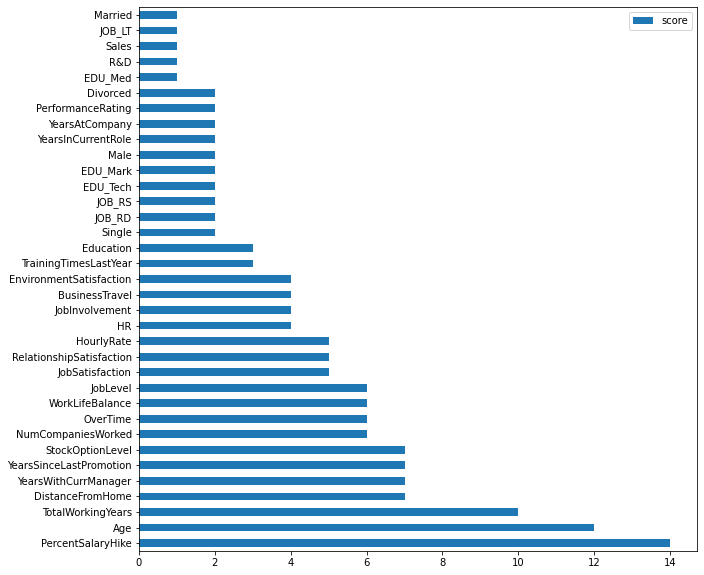

In [34]:
final_grid_fit=gbm_ins.fit(X_train, y_train)
feature_important = final_grid_fit.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
importance = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
importance.plot(kind='barh',figsize=(10,10))
plt.show()

### Predikce

In [35]:
y_pred_XG = gbm_ins.predict(X_test)


conf_xg = metrics.confusion_matrix(y_test, y_pred_XG)
conf_xg

cnf_xgb=confusion_matrix(y_test,y_pred_XG)
cnf_xgb_pd=pd.DataFrame(cnf_xgb, columns = ['False','True'], index = ['False','True'])
cnf_xgb_pd


,False,True
False,351,18
True,36,36


### Metriky

In [36]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_XG)) # ((TP+TN)/total) 
print("Precision:",metrics.precision_score(y_test, y_pred_XG)) # (TP/(TP + FP)) 
print("Recall:",metrics.recall_score(y_test, y_pred_XG)) # (TP/(TP + FN)) 
print("False Negative Rate:",cnf_xgb[1,0]/cnf_xgb.sum()) # (TP/(TP + FN)) 

Accuracy: 0.8775510204081632
Precision: 0.6666666666666666
Recall: 0.5
False Negative Rate: 0.08163265306122448


# 4) Vyhodnocení  

In [37]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_XG)) # ((TP+TN)/total) 
print("Precision:",metrics.precision_score(y_test, y_pred_XG)) # (TP/(TP + FP)) 
print("Recall:",metrics.recall_score(y_test, y_pred_XG)) # (TP/(TP + FN)) 
print("False Negative Rate:",cnf_xgb[1,0]/cnf_xgb.sum()) # (TP/(TP + FN)) 


acc=np.array([metrics.accuracy_score(y_test, y_pred_log),metrics.accuracy_score(y_test, y_pred_tree),metrics.accuracy_score(y_test, y_pred_XG)])
prec=np.array([metrics.precision_score(y_test, y_pred_log),metrics.precision_score(y_test, y_pred_tree),metrics.precision_score(y_test, y_pred_XG)])
rec=np.array([metrics.recall_score(y_test, y_pred_log),metrics.recall_score(y_test, y_pred_tree),metrics.recall_score(y_test, y_pred_XG)])
FNR=np.array([cnf_log[1,0]/cnf_log.sum(),cnf_tree[1,0]/cnf_tree.sum(),cnf_xgb[1,0]/cnf_xgb.sum()])

results_np=np.array([acc,prec,rec,FNR])


results = pd.DataFrame(results_np, columns = ['Logit','Decision Tree','XGB Logit'], index = ['Accuracy','Precision','Recall','False Negative Rate'])
results

Accuracy: 0.8775510204081632
Precision: 0.6666666666666666
Recall: 0.5
False Negative Rate: 0.08163265306122448


,Logit,Decision Tree,XGB Logit
Accuracy,0.875283,0.848073,0.877551
Precision,0.707317,0.580645,0.666667
Recall,0.402778,0.250000,0.500000
False Negative Rate,0.097506,0.122449,0.081633


### XGB je sice o něco přesnější ale upřednostnili bychom Logit kvůli lepší interpretovatelnosti